# Recommender Systems 

## PART 1: Playing with Data

### Importing packages

In [44]:
import pandas as pd
import math
from math import sqrt
import numpy as np
import datetime
import statsmodels.formula.api as sm
import statsmodels.stats.diagnostic as sms


#    -- Scikit Learn --
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
##  Importing a package for Using Ridge and Lasso Analysis
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale
##  Splitting the Data Set into two Folds: Training and Testing using train_test_split()
from sklearn.cross_validation import train_test_split
##  Tool for calculating MSE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale


#    -- Packages for Visualization --
import seaborn as sns
##  Plotly
import plotly
from plotly.graph_objs import *
import plotly.offline as plot
plot.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
##  Scatter Plot
from pandas.tools.plotting import scatter_matrix
##  Matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline


#   -- Packages for t-SNE Algorithm --
from skdata.mnist.view import OfficialImageClassification
from matplotlib import pyplot as plt
from tsne import bh_sne

### Reading Files

In [45]:
user_data = pd.read_table('u.data', sep='\t', names=['user id', 'item id', 'rating', 'timestamp'])

In [46]:
user_user = pd.read_table('u.user', sep='|',names=['user id', 'age', 'gender', 'occupation', 'zip code'])

### 1. Distribution of Age group across all users

In [47]:
data = [go.Histogram(x = user_user.age)]

layout = dict(xaxis = dict(title = 'Age'), yaxis = dict(title ='Frequency'))
              
fig = dict(data = data, layout = layout)                      
plot.iplot(fig, 'Distribution of Age-Group across all users')

### 2. Distribution of Ratings across all users

In [48]:
data = [go.Histogram(x = user_data.rating)]

layout = dict(xaxis = dict(title = 'Ratings'), yaxis = dict(title ='Frequency'))
              
fig = dict(data = data, layout = layout)                      
plot.iplot(fig, 'Distribution of Ratings for Movies across all users')

### 3. Average Rating over the years 1997-98

In [49]:
# Converting Uinx timestamp into Date format
user_data.timestamp = pd.to_datetime(user_data.timestamp, unit='s')
user_data['date'] = user_data.timestamp.dt.date

In [50]:
Average_rating_Date = pd.DataFrame(user_data.groupby(['date']).rating.mean(), index=None)

trace0 = Scatter(
        x = Average_rating_Date.index,
        y = Average_rating_Date.rating,
)
data = [trace0]
layout = dict(xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Mean Ratings'),
              )
fig = dict(data = data, layout = layout)
plot.iplot(fig, filename='Rating Scatter Histogram')

### 4.  Stacked Bar Plot Based on Gender for Average Ratings Vs Age group

In [51]:
# Merged the two Dataframes into one DataFrame
Final_table = pd.merge(user_data, user_user, on='user id')

#### Using Pivot Table to form a DF with Gender based Avg Ratings

In [52]:
# Using Pivot Table -
AvgRating_Age_Gender = pd.pivot_table(Final_table, index=['age','gender'], aggfunc='mean')

# Unstack the index(Gender) to Column, with values = Average Ratings
AvgRating_Age_Gender = AvgRating_Age_Gender.unstack().drop(['item id', 'user id'], axis=1)

# OR Using groupby(): pd.DataFrame(Final_table.groupby(['age','gender']).rating.mean()).unstack().head() 

#### Forming Age Intervals

In [53]:
AvgR_A_G = AvgRating_Age_Gender.copy()
AvgR_A_G.reset_index(inplace = True)

In [54]:
AvgR_A_G['Interval'] = pd.cut(AvgR_A_G['age'], bins=[6, 10, 20, 30, 40, 50, 60, 70, 80], labels=False)
labels = np.array('7-10 11-20 21-30 31-40 41-50 51-60 61-70 71-80'.split())
AvgR_A_G['Interval'] = labels[AvgR_A_G['Interval']]

In [55]:
AvgR_A_G = pd.DataFrame(AvgR_A_G.groupby(['Interval']).mean(), index =None)

/home/user/StackRoute/Recommendation_Model/lib/python3.6/site-packages/pandas/core/base.py:324: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [56]:
AvgR_A_G.Interval = AvgR_A_G.Interval.astype(str)

##### Using Plotly

In [57]:
trace0 = Bar(
            x = AvgR_A_G.age,
            y = AvgR_A_G.rating.M,
            name = 'Male'
            )
trace1 = Bar(
            x = AvgR_A_G.age,
            y = AvgR_A_G.rating.F,
            name = 'Female')
data = [trace0 , trace1]
layout = dict(xaxis = dict(title = 'Age Range'),
              yaxis = dict(title = 'Ratings'),
              barmode = 'stack')
fig = dict(data = data, layout = layout)
plot.iplot(fig, 'Gender ratings')

### 5. Occupation by Average Rating

##### Using Plotly

In [58]:
occupation_rating = pd.DataFrame(Final_table.groupby(['occupation']).rating.mean(), index=None)

In [59]:
trace0 = Bar(
        x = occupation_rating.index,
        y = occupation_rating.rating,
        
)
data = [trace0]
layout = dict(xaxis = dict(title = 'Age'),
              yaxis = dict(title = 'Average Rating'),
              barmode='group'
              )
fig = dict(data = data, layout = layout)
plot.iplot(fig, filename='Average rating vs occupation')

## PART B: Recommender Systems : Memory Based CF

##### Method 1: Taking the entire Data Set

In [60]:
user_data.shape

(100000, 5)

#### Total Users and Items

In [61]:
n_users = user_data['user id'].unique().shape[0]
n_items = user_data['item id'].unique().shape[0]

print("Number of users = " + str(n_users) + " | Number of movies = " + str(n_items))  

Number of users = 943 | Number of movies = 1682


#### Splitting into Testing and Training units

In [62]:
train_data, test_data = train_test_split(user_data, random_state=4, train_size=.80, test_size=.20)

#### Creating  USER - ITEM  Matrix: Rows = Users,  Cols = Items

In [63]:
# (Training) User x Item Matrix --
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  
    
    
# (Testing) User x Item Matrix --
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

#### Pairwise Distances Similarity: d(V1, V2)

In [64]:
# user - user similarity Matrix (943x943) :
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')

# item -item similarity Matrix (1682x1682) :
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

#### Cosine Similarity: Sim(V1, V2)

In [65]:
# user - user similarity Matrix (943x943) :
cosine_user_similarity = 1 - user_similarity

# item -item similarity Matrix (1682x1682) :
cosine_item_similarity = 1 - item_similarity


# We can use 'cosine_similarity' method directly, but for missing values in the dataset it puts NAN!! 
# cosine_user_similarity = cosine_similarity(train_data_matrix[:,:], train_data_matrix)
# cosine_item_similarity = cosine_similarity(train_data_matrix.T[:,:], train_data_matrix.T)

#### Predictions

In [66]:
def predict(ratings, similarity, type='user'):
    
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred


# user - user CF:
user_prediction = predict(train_data_matrix, cosine_user_similarity, type='user')
# item - item CF:
item_prediction = predict(train_data_matrix, cosine_item_similarity, type='item')

#### Evaluation Method: RMSE

In [67]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 2.910064985348684
Item-based CF RMSE: 3.1299369104509904


##### Method 2



##  K-NN Aproach using SURPRISE API

#### Importing Packages 

In [68]:
import os
import pandas as pd
from surprise import KNNWithMeans
from surprise import Dataset                                                     
from surprise import Reader                                                      
from surprise.accuracy import rmse

Surprise offers two ways of loading a custom dataset:

1. You can either specify a single file with all the ratings and use the split () method to perform cross-validation

2. If your dataset is already split into predefined folds, you can specify a list of files for training and testing.

#### Loading a dataset with predefined folds

In [70]:
# Path-Names storing Training Data and Testing Data
train_file = os.path.expanduser('~') + '/StackRoute/Recommendation_Model/ml-100k/u1.base'
test_file = os.path.expanduser('~') + '/StackRoute/Recommendation_Model/ml-100k/u1.test'

# Surprise API Dataset ( Reader parses the file containing data )
data = Dataset.load_from_folds([(train_file, test_file)], Reader('ml-100k'))

In [71]:
# Using Surprise Algorithm: KNNWithmeans(K_value) 
algo = KNNWithMeans(k=45, min_k=1, sim_options={'name':'cosine', 'user_based':True})                                                       
    
# Predicting Value
for trainset, testset in data.folds(): 
    algo.train(trainset)                             
    predictions = algo.test(testset)
    rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9698


In [72]:
# Let's build a pandas dataframe with all the predictions

def get_Iu(uid):
    """Return the number of items rated by given user"""
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item"""
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

# Converting Surprise dataset into Dataframe 
df = pd.DataFrame(predictions, columns=['user_id', 'item_id', 'ratings_ui', 'estimated_Ratings', 'details'])    
df['Iu'] = df.user_id.apply(get_Iu)
df['Ui'] = df.item_id.apply(get_Ui)
# Calculating Error = (Predicted Rating - Actual Rating)
df['ERROR IN PREDICTION'] = abs(df.estimated_Ratings - df.ratings_ui)

In [73]:
df.head()

,user_id,item_id,ratings_ui,estimated_Ratings,details,Iu,Ui,ERROR IN PREDICTION
0,1,6,5.0,3.707803,"{'actual_k': 20, 'was_impossible': False}",135,20,1.292197
1,1,10,3.0,3.947668,"{'actual_k': 45, 'was_impossible': False}",135,73,0.947668
2,1,12,5.0,4.313281,"{'actual_k': 45, 'was_impossible': False}",135,211,0.686719
3,1,14,5.0,4.092845,"{'actual_k': 45, 'was_impossible': False}",135,140,0.907155
4,1,17,3.0,3.536435,"{'actual_k': 45, 'was_impossible': False}",135,72,0.536435


In [74]:
best_predictions = df.sort_values(by='ERROR IN PREDICTION')[:10]
worst_predictions = df.sort_values(by='ERROR IN PREDICTION')[-10:]

In [75]:
# Best predictions of the algorithm
best_predictions

,user_id,item_id,ratings_ui,estimated_Ratings,details,Iu,Ui,ERROR IN PREDICTION
19164,405,759,1.0,1.0,"{'actual_k': 6, 'was_impossible': False}",582,6,0.0
7977,181,978,1.0,1.0,"{'actual_k': 20, 'was_impossible': False}",218,20,0.0
7985,181,1001,1.0,1.0,"{'actual_k': 11, 'was_impossible': False}",218,11,0.0
19192,405,1177,1.0,1.0,"{'actual_k': 6, 'was_impossible': False}",582,6,0.0
19193,405,1178,1.0,1.0,"{'actual_k': 14, 'was_impossible': False}",582,14,0.0
7991,181,1040,1.0,1.0,"{'actual_k': 19, 'was_impossible': False}",218,19,0.0
7993,181,1049,1.0,1.0,"{'actual_k': 19, 'was_impossible': False}",218,19,0.0
8001,181,1087,1.0,1.0,"{'actual_k': 9, 'was_impossible': False}",218,9,0.0
8003,181,1094,1.0,1.0,"{'actual_k': 8, 'was_impossible': False}",218,8,0.0
19430,415,1524,5.0,5.0,"{'actual_k': 5, 'was_impossible': False}",21,6,0.0


It's interesting to note that these perfect predictions are actually lucky shots: $|U_i|$ is always very small, meaning that very few users have rated the target item. This implies that the set of neighbors is very small (see the ``actual_k`` field)... And, it just happens that all the ratings from the neighbors are the same (and mostly, are equal to that of the target user).

This may be a bit surprising but these lucky shots are actually very important to the accuracy of the algorithm... Try running the same algorithm with a value of ``min_k`` equal to $10$. This means that if there are less than $10$ neighbors, the prediction is set to the mean of all ratings. You'll see your accuracy decrease!

In [76]:
# Worst predictions of the algorithm (ie. with the biggest error)
worst_predictions

,user_id,item_id,ratings_ui,estimated_Ratings,details,Iu,Ui,ERROR IN PREDICTION
788,12,200,1.0,4.479832,"{'actual_k': 45, 'was_impossible': False}",25,165,3.479832
19123,405,451,5.0,1.496481,"{'actual_k': 45, 'was_impossible': False}",582,138,3.503519
9514,212,180,1.0,4.549670,"{'actual_k': 45, 'was_impossible': False}",17,179,3.549670
15290,312,157,1.0,4.585035,"{'actual_k': 45, 'was_impossible': False}",130,99,3.585035
7861,181,25,5.0,1.406794,"{'actual_k': 45, 'was_impossible': False}",218,231,3.593206
7390,167,169,1.0,4.658633,"{'actual_k': 45, 'was_impossible': False}",38,97,3.658633
13972,295,183,1.0,4.689208,"{'actual_k': 45, 'was_impossible': False}",100,223,3.689208
15286,312,144,1.0,4.761963,"{'actual_k': 45, 'was_impossible': False}",130,195,3.761963
15306,312,265,1.0,4.779180,"{'actual_k': 45, 'was_impossible': False}",130,169,3.779180
19140,405,575,5.0,1.000000,"{'actual_k': 36, 'was_impossible': False}",582,36,4.000000


Let's focus first on the last two predictions. Well, we can't do much about them. We should have predicted $5$, but the only available neighbor had a rating of $1$, so we were screwed. The only way to avoid this kind of errors would be to increase the ``min_k`` parameter, but it would actually worsen the accuracy (see note above).

How about the other ones? It seems that for each prediction, the users are some kind of outsiders: they rated their item with a rating of $1$ when the most of the ratings for the item where high (or inversely, rated a *bad* item with a rating of $5$). See the plot below as an illustration for the first rating.

These are situations where baseline estimates would be quite helpful, in order to deal with highly biased users (and items).

<IPython.core.display.Javascript object>


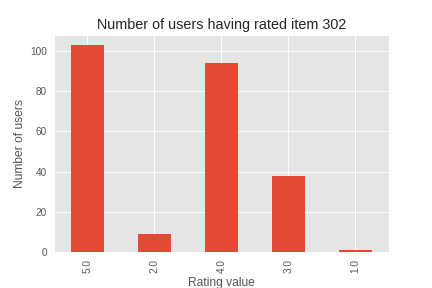

In [77]:
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.style.use('ggplot')

counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid('302')]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title('Number of users having rated item 302')

.



## Visualization with t-SNE Algorithm: Dimensional Reduction

In [38]:
# Loading up data in 3 Dimensions
x_data = np.array(train_data['user id'])
y_data = np.array(train_data['item id'])
z_data = np.array(Final_table['age'])

In [39]:
# convert image data to float64 matrix. float64 is need for bh_sne
x_data = np.asarray(x_data).astype('float64')
x_data = x_data.reshape((x_data.shape[0], -1))

y_data = np.asarray(y_data).astype('float64')
y_data = y_data.reshape((y_data.shape[0], -1))

z_data = np.asarray(z_data).astype('float64')
z_data = z_data.reshape((z_data.shape[0], -1))

In [40]:
# Performing t-SNE embedding on all 3 Dimensions
vis_z = bh_sne(z_data)

In [ ]:
#plt.scatter(vis_x[:,0], vis_x[:,1], c=y_data, cmap=plt.cm.get_cmap("jet", 10))
#plt.colorbar(ticks=range(10))
#plt.clim(-0.5, 9.5)
#plt.show()

plt.scatter(vis_z[:,0], vis_z[:,1], c=y_data, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()